# Import Libraries

In [22]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import os
import joblib
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import joblib
import os

import requests
from io import StringIO
from Sastrawi.StopWordRemover.StopWordRemover import StopWordRemover
from Sastrawi.Dictionary.ArrayDictionary import ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

plt.style.use('default')
sns.set_palette("husl")

# 1. Data Loading 

In [23]:
import pandas as pd

# 1. Load Single Dataset
file_path = "D:\\Kuliah\\Skripsi\\Scraping\\Balancing\\Oversampling\\Validator\\hasil_validator_processed.csv"

print("LOADING DATASET: TIGA PUTRA")
print("=" * 35)

print("CHECKING RAW FILE STRUCTURE:")
with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()[:5]  # 5 baris pertama
    for i, line in enumerate(lines):
        print(f"Line {i}: {repr(line.strip())}")
        semicolon_count = line.count(';')
        print(f"  Semicolons: {semicolon_count}")

print("\n" + "=" * 50)

try:
    # Load dengan delimiter semicolon dan drop kolom kosong
    df = pd.read_csv(
        file_path,
        encoding='utf-8',
        sep=';',
        on_bad_lines='skip',
        engine='python'
    )

    print("Dataset loaded successfully.")
    print(f"Original columns: {list(df.columns)}")

    # Hapus kolom kosong atau unnamed
    cols_to_keep = [col for col in df.columns if not col.startswith('Unnamed')]
    df = df[cols_to_keep]
    print(f"After removing unnamed columns: {list(df.columns)}")

    # Pastikan hanya ada 4 kolom
    if len(df.columns) > 4:
        df = df.iloc[:, :4]
        df.columns = ['name', 'date', 'rating', 'text']
    elif len(df.columns) == 4:
        df.columns = ['name', 'date', 'rating', 'text']

    print(f"Final columns: {list(df.columns)}")

except UnicodeDecodeError:
    df = pd.read_csv(
        file_path,
        encoding='ISO-8859-1',
        sep=';',
        on_bad_lines='skip',
        engine='python'
    )
    print("Loaded using fallback encoding (ISO-8859-1).")

# 2. Dataset overview
print("\nDATASET OVERVIEW:")
print(f"Total Reviews: {df.shape[0]}")
print(f"Columns: {list(df.columns)}")

# 3. Data structure verification
print("\nDATA STRUCTURE VERIFICATION:")
for i, col in enumerate(df.columns):
    sample_values = df[col].head(3).tolist()
    print(f"Column {i} ('{col}'): {sample_values}")

# 4. Basic statistics
print("\nBASIC STATISTICS:")
total_missing = df.isnull().sum().sum()
print(f"Missing values (total): {total_missing}")

print("Missing values per column:")
for col in df.columns:
    missing = df[col].isnull().sum()
    print(f"  {col}: {missing} ({missing/len(df)*100:.1f}%)")

if 'text' in df.columns:
    non_empty_text = df['text'][df['text'].notna() & (df['text'] != '')]
    if len(non_empty_text) > 0:
        total_duplicates = non_empty_text.duplicated().sum()
        duplicate_percent = (total_duplicates / len(non_empty_text)) * 100
        print(f"Duplicates in non-empty text: {total_duplicates} ({duplicate_percent:.1f}%)")

# 5. Rating distribution
print("\nRATING DISTRIBUTION:")
if 'rating' in df.columns:
    ratings = df['rating'].astype(str).str.replace(',', '.', regex=False)
    ratings = pd.to_numeric(ratings, errors='coerce')
    ratings = ratings.round().astype('Int64')

    valid_ratings = ratings[(ratings >= 1) & (ratings <= 5)]

    if len(valid_ratings) > 0:
        rating_dist = valid_ratings.value_counts().sort_index()
        total_valid = len(valid_ratings)

        for rating in [1, 2, 3, 4, 5]:
            count = rating_dist.get(rating, 0) if rating in rating_dist.index else 0
            percentage = (count / total_valid) * 100 if total_valid > 0 else 0
            print(f"  {rating} rating: {count} reviews ({percentage:.1f}%)")

        missing_ratings = ratings.isnull().sum()
        if missing_ratings > 0:
            print(f"  Missing ratings: {missing_ratings} ({missing_ratings/len(df)*100:.1f}%)")
    else:
        print("No valid ratings found (1-5 scale).")
        print(f"Sample rating values: {df['rating'].head().tolist()}")

# 6. Data preview
print("\nDATA PREVIEW:")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)
print(df.head(10))

# 7. Review text analysis (Revised)
if 'text' in df.columns:
    
    # 1. Hitung Ulasan yang Dihilangkan karena Kosong/Null
    empty_reviews = (df['text'] == '').sum()
    null_reviews = df['text'].isnull().sum()
    total_empty_or_null = empty_reviews + null_reviews
    
    # 2. Hitung Ulasan Valid (yang memiliki teks) sebelum hapus duplikat
    valid_reviews_pre_dedupe = len(df) - total_empty_or_null
    
    # 3. Hitung Duplikat di antara Ulasan Valid
    # Menggunakan df.copy() untuk menghindari SettingWithCopyWarning
    df_valid = df[df['text'].notna() & (df['text'] != '')].copy()
    total_duplicates = df_valid['text'].duplicated().sum()
    
    # 4. Hitung Ulasan Valid Akhir
    valid_reviews_final = valid_reviews_pre_dedupe - total_duplicates
    
    print("\n📝 REVIEW TEXT STATUS (DETAIL):")
    print("-" * 40)
    print(f"Total Reviews Awal: {len(df):,}")
    print("-" * 40)
    
    # Kategori 1: Data yang dihilangkan karena kekurangan konten (Empty/Null)
    print(f"1. Ulasan Kosong/Null (Dihilangkan):")
    print(f"   - Null (NaN): {int(null_reviews):,}")
    print(f"   - Empty String (''): {int(empty_reviews):,}")
    print(f"   - Total Kosong/Null: {int(total_empty_or_null):,} ({total_empty_or_null/len(df)*100:.1f}%)")
    print("-" * 40)
    
    # Kategori 2: Data yang memiliki teks tapi duplikat
    print(f"2. Ulasan Duplikat (Dihilangkan):")
    print(f"   - Total Duplikat (di antara non-empty): {int(total_duplicates):,} ({total_duplicates/len(df)*100:.1f}%)")
    print("-" * 40)
    
    # Kategori 3: Data yang dapat diproses
    print(f"3. Ulasan Valid Akhir (Siap Proses):")
    print(f"   - Total Ulasan Valid Akhir: {int(valid_reviews_final):,} ({valid_reviews_final/len(df)*100:.1f}%)")
    print("-" * 40)
    
    total_eliminated = total_empty_or_null + total_duplicates
    print(f"Total Data Dieliminasi: {int(total_eliminated):,} (Kosong/Null + Duplikat)")
    print(f"Verifikasi: {valid_reviews_final + total_eliminated:,} = {len(df):,}")


LOADING DATASET: TIGA PUTRA
CHECKING RAW FILE STRUCTURE:
Line 0: 'processed_text;hasil_validator'
  Semicolons: 1
Line 1: 'saya kecewa sudah nungu lebih dari jam nyata barang tidak ada jelek;negative'
  Semicolons: 1
Line 2: 'kecewa banget ke sini baru pertama kali kesini saya jauh datang dari luar kota hp yang saya order awal bilang ada nyata hpnya zonk parah lagi saya sudah ngu lebih dari satu jam kecewa;negative'
  Semicolons: 1
Line 3: 'saya beli hp kata ada mulai belum maghrib sampai habis isya nyata barang tidak ada tipu tipu;negative'
  Semicolons: 1
Line 4: 'layan ramah dan baik sekali;positive'
  Semicolons: 1

Dataset loaded successfully.
Original columns: ['processed_text', 'hasil_validator']
After removing unnamed columns: ['processed_text', 'hasil_validator']
Final columns: ['processed_text', 'hasil_validator']

DATASET OVERVIEW:
Total Reviews: 1663
Columns: ['processed_text', 'hasil_validator']

DATA STRUCTURE VERIFICATION:
Column 0 ('processed_text'): ['saya kecewa sudah

# 4. PREPROCESSING SETUP


In [24]:
# Initialize tools
stemmer = StemmerFactory().create_stemmer()
stopword_remover = StopWordRemoverFactory().create_stop_word_remover()

# Load positive & negative lexicon
positive_url = "https://raw.githubusercontent.com/fajri91/InSet/master/positive.tsv"
negative_url = "https://raw.githubusercontent.com/fajri91/InSet/master/negative.tsv"

pos_data = pd.read_csv(StringIO(requests.get(positive_url).text), sep='\t', header=None)
neg_data = pd.read_csv(StringIO(requests.get(negative_url).text), sep='\t', header=None)

inset_positive = pos_data[0].tolist()
inset_negative = neg_data[0].tolist()

# Load slang dictionary
slang_url = "https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv"
slang_data = pd.read_csv(StringIO(requests.get(slang_url).text))

slang_dict = {}
for _, row in slang_data.iterrows():
    slang = str(row.iloc[0]).lower().strip()
    formal = str(row.iloc[1]).lower().strip()
    if slang != 'nan' and formal != 'nan':
        slang_dict[slang] = formal

print(f" Loaded: {len(inset_positive)} positive, {len(inset_negative)} negative words")
print(f" Loaded: {len(slang_dict)} slang mappings")

slang_dict = {}
for _, row in slang_data.iterrows():
    slang = str(row.iloc[0]).lower().strip()
    formal = str(row.iloc[1]).lower().strip()
    if slang != 'nan' and formal != 'nan':
        slang_dict[slang] = formal

print(f" Loaded: {len(slang_dict)} slang mappings")

# TAMBAHAN: Initialize Stemmer
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()
print(" Stemmer initialized")

print(f" Loaded: {len(inset_positive)} positive, {len(inset_negative)} negative words")
print(f" Loaded: {len(slang_dict)} slang mappings")

# Tambahkan setelah bagian loading lexicon
# Initialize Stemmer (PERBAIKAN: Tambahkan yang hilang)
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

print(" Stemmer initialized")

 Loaded: 3610 positive, 6610 negative words
 Loaded: 4330 slang mappings
 Loaded: 4330 slang mappings
 Stemmer initialized
 Loaded: 3610 positive, 6610 negative words
 Loaded: 4330 slang mappings
 Stemmer initialized


# Feature Engineering

## Preparing Data

In [28]:
# ===================================================================
# 1. PREPARE DATA FOR MACHINE LEARNING (BINARY ONLY)
# ===================================================================
print("\n1️. PREPARING DATA FOR MACHINE LEARNING...")

# Cek distribusi awal sebelum dihapus
print("Initial Class Distribution (Before Filtering):")
print(['sentiment'].value_counts())

# --- TAMBAHAN KODE: HAPUS LABEL NETRAL ---
print("\nRemoving 'neutral' data...")
# Filter hanya mengambil data yang labelnya BUKAN 'neutral'
df_binary = 'sentiment' != 'neutral'.copy()

# Reset index agar data tetap rapi
df_binary.reset_index(drop=True, inplace=True)
# ------------------------------------------

# Ambil data dari df_binary (yang sudah tanpa netral)
X = df_binary['processed_text'].tolist()
y = df_binary['sentiment'].tolist()

print(f"\n Total samples (Positive & Negative only): {len(X)}")
print(f" Features: processed_text")
print(f" Target: sentiment")

# Check class distribution after filtering
from collections import Counter
class_dist = Counter(y)
print(f"\n Final Class Distribution:")
for class_name, count in class_dist.items():
    percentage = (count/len(y))*100
    print(f"  {class_name}: {count} ({percentage:.1f}%)")


1️. PREPARING DATA FOR MACHINE LEARNING...
Initial Class Distribution (Before Filtering):


AttributeError: 'list' object has no attribute 'value_counts'

## Pembagian Data (Stratified Sampling)

In [ ]:
# ===================================================================
# 2. TRAIN-TEST SPLIT
# ===================================================================
print("\n2. SPLITTING DATA...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f" Training set: {len(X_train)} samples")
print(f" Test set: {len(X_test)} samples")

# Check split distribution
train_dist = Counter(y_train)
test_dist = Counter(y_test)

print(f"\n Training Distribution:")
for class_name, count in train_dist.items():
    percentage = (count/len(y_train))*100
    print(f"  {class_name}: {count} ({percentage:.1f}%)")

print(f"\n Test Distribution:")
for class_name, count in test_dist.items():
    percentage = (count/len(y_test))*100
    print(f"  {class_name}: {count} ({percentage:.1f}%)")


2. SPLITTING DATA...
 Training set: 878 samples
 Test set: 220 samples

 Training Distribution:
  positive: 712 (81.1%)
  negative: 166 (18.9%)

 Test Distribution:
  positive: 178 (80.9%)
  negative: 42 (19.1%)


## Fitur Ekstraksi (TF-IDF Vectorization)

In [ ]:
# ===================================================================
# 3. TF-IDF VECTORIZATION
# ===================================================================
print("\n3️. TF-IDF VECTORIZATION...")

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2),
    stop_words=None  # Sudah dihapus di preprocessing
)

# Fit and transform training data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f" TF-IDF features: {X_train_tfidf.shape[1]}")
print(f" Training matrix shape: {X_train_tfidf.shape}")
print(f" Test matrix shape: {X_test_tfidf.shape}")


3️. TF-IDF VECTORIZATION...
 TF-IDF features: 1506
 Training matrix shape: (878, 1506)
 Test matrix shape: (220, 1506)


## Random Over-Sampling

In [ ]:
# ============================================================
# 4. OVERSAMPLING (ONLY TRAIN SET)
# ============================================================
from imblearn.over_sampling import RandomOverSampler

print("\n4. BALANCING (Oversampling on TRAIN only)...")

ros = RandomOverSampler(random_state=42)

X_train_balanced, y_train_balanced = ros.fit_resample(
    X_train_tfidf, y_train
)

print("\nTRAIN BEFORE balancing:", Counter(y_train))
print("TRAIN AFTER  balancing:", Counter(y_train_balanced))
print("TEST:", Counter(y_test))



4. BALANCING (Oversampling on TRAIN only)...

TRAIN BEFORE balancing: Counter({'positive': 712, 'negative': 166})
TRAIN AFTER  balancing: Counter({'positive': 712, 'negative': 712})
TEST: Counter({'positive': 178, 'negative': 42})


# Modelling

## Training (Support Vector Machine)

In [ ]:
# ============================================================
# 5. SVM MODEL TRAINING
# ============================================================
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

print("\n5. SVM MODEL TRAINING...")

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm = SVC(random_state=42)

grid_search = GridSearchCV(
    svm,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Training with oversampled data
grid_search.fit(X_train_balanced, y_train_balanced)

# Best model
best_svm = grid_search.best_estimator_

print("\nBest Params:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Predict on balanced training set
y_train_pred = best_svm.predict(X_train_balanced)

train_accuracy = accuracy_score(y_train_balanced, y_train_pred)

print(f"\nTraining Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")


5. SVM MODEL TRAINING...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Score: 0.9894712132443786

Training Accuracy: 0.9993 (99.93%)


## Klasifikasi (Support Vector Machine)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# ===================================================================
# 6. SVM MODEL CLASSIFICATION
# ===================================================================

print("\n5. SVM MODEL CLASSIFICATION...")

# 1. Prediksi pada test set
# -------------------------------------------------------
print(" Melakukan prediksi pada test set...")

# Gunakan X_test_tfidf (data test yang sudah di-vektorisasi)
y_pred = best_svm.predict(X_test_tfidf)

# Coba hitung probabilitas (Confidence Score)
# Hanya bekerja jika SVM didefinisikan dengan SVC(probability=True)
try:
    y_pred_proba = best_svm.predict_proba(X_test_tfidf)
    has_proba = True
except AttributeError:
    has_proba = False
    print(" Info: Confidence score tidak tampil karena model dilatih tanpa probability=True")

# 2. Hitung Akurasi
# -------------------------------------------------------
test_accuracy = accuracy_score(y_test, y_pred)
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# 3. Tampilkan beberapa prediksi sample
# -------------------------------------------------------
print(f"\nSample Prediksi:")

# Konversi y_test dan X_test ke array agar mudah di-indexing angka
y_test_array = np.array(y_test)
X_test_array = np.array(X_test) # Mengambil teks asli untuk ditampilkan

# Ambil 5 indeks acak
sample_indices = np.random.choice(len(y_test), 5, replace=False)

for i, idx in enumerate(sample_indices):
    text_snippet = X_test_array[idx]
    # Potong teks jika terlalu panjang agar rapi
    if len(text_snippet) > 40:
        text_snippet = text_snippet[:40] + "..."
        
    actual = y_test_array[idx]
    predicted = y_pred[idx]
    
    # Format output confidence
    if has_proba:
        confidence = np.max(y_pred_proba[idx]) # Ambil probabilitas kelas yang diprediksi
        conf_str = f", Confidence={confidence:.3f}"
    else:
        conf_str = ""

    print(f"  Sample {i+1}: Text='{text_snippet}', Actual={actual}, Predicted={predicted}{conf_str}")

print("=" * 50)


5. SVM MODEL CLASSIFICATION...
 Melakukan prediksi pada test set...
 Info: Confidence score tidak tampil karena model dilatih tanpa probability=True
  Test Accuracy: 0.9045 (90.45%)

Sample Prediksi:
  Sample 1: Text='layan muas mbak ramah', Actual=positive, Predicted=positive
  Sample 2: Text='alam sangat enggak enak waktu hujan dera...', Actual=positive, Predicted=positive
  Sample 3: Text='layan ramah sangat bantu kali beli sini ...', Actual=positive, Predicted=positive
  Sample 4: Text='tempat layan', Actual=negative, Predicted=negative
  Sample 5: Text='beli hp puas banget layan ramah baik', Actual=positive, Predicted=positive


# Evaluasi Model

In [ ]:
# ===================================================================
# 6. MODEL EVALUATION
# ===================================================================
from sklearn.metrics import accuracy_score, classification_report

print("\n6. MODEL EVALUATION...")

y_pred = best_svm.predict(X_test_tfidf)

test_acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_acc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# ===================================================================
# 7. SAVE MODEL
# ===================================================================
print("\n7. SAVING MODEL...")

# Create model directory if not exists
model_dir = "D:\\Kuliah\\Skripsi\\Scraping\\model_hasil\\"
os.makedirs(model_dir, exist_ok=True)

# Save model and vectorizer
model_path = os.path.join(model_dir, "svm_sentiment_model.pkl")
vectorizer_path = os.path.join(model_dir, "tfidf_vectorizer.pkl")

joblib.dump(best_svm, model_path)
joblib.dump(tfidf, vectorizer_path)

print(f" Model saved: {model_path}")
print(f" Vectorizer saved: {vectorizer_path}")

# Set variables for later use
svm_model_loaded = best_svm
tfidf_loaded = tfidf

print(f"\n MODEL TRAINING COMPLETED!")
print(f"   - Best Model: SVM with {grid_search.best_params_}")
print(f"   - Training Accuracy: {train_accuracy:.4f}")
print(f"   - Test Accuracy: {test_accuracy:.4f}")
print("="*60)


6. MODEL EVALUATION...
Test Accuracy: 0.9045454545454545

Classification Report:
              precision    recall  f1-score   support

    negative       0.96      0.52      0.68        42
    positive       0.90      0.99      0.94       178

    accuracy                           0.90       220
   macro avg       0.93      0.76      0.81       220
weighted avg       0.91      0.90      0.89       220


7. SAVING MODEL...
 Model saved: D:\Kuliah\Skripsi\Scraping\model_hasil\svm_sentiment_model.pkl
 Vectorizer saved: D:\Kuliah\Skripsi\Scraping\model_hasil\tfidf_vectorizer.pkl

 MODEL TRAINING COMPLETED!
   - Best Model: SVM with {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
   - Training Accuracy: 0.9993
   - Test Accuracy: 0.9045


In [ ]:
# ===================================================================
# 8. GENERATE & SAVE SVM PREDICTIONS (FOR SWOT ANALYSIS)
# ===================================================================
print("\n8. GENERATING & SAVING SVM LABELS FOR SWOT...")

# 1. Ambil seluruh data teks yang sudah dipreprocess dari df_clean
# Pastikan kolom 'processed_text' tidak ada yang kosong (NaN)
all_texts = df_clean['processed_text'].fillna("")

# 2. Vektorisasi seluruh data menggunakan TF-IDF yang sudah dilatih
# PENTING: Gunakan .transform() (bukan fit_transform) agar kosa katanya sama dengan saat training
X_full_tfidf = tfidf_loaded.transform(all_texts)

# 3. Prediksi sentimen untuk SELURUH data menggunakan model SVM terbaik
# Ini akan menghasilkan label 'positive' atau 'negative' versi SVM
svm_predictions = best_svm.predict(X_full_tfidf)

# 4. Buat DataFrame baru untuk keperluan SWOT (Data asli + Label SVM)
# Kita salin data asli (tanggal, rating, teks) agar lengkap untuk analisis SWOT
df_swot_svm = df_clean[['date', 'rating', 'text']].copy()

# Masukkan hasil prediksi SVM ke dalam kolom 'sentiment'
# Kolom ini akan menimpa/menggantikan label lama (Lexicon) dengan label baru (SVM)
df_swot_svm['sentiment'] = svm_predictions

# 5. Simpan ke file CSV baru
output_svm_file = 'swot_dataset_svm_final_validator.csv'
df_swot_svm.to_csv(output_svm_file, index=False)

print(f" File dataset labeling SVM berhasil dibuat: {output_svm_file}")
print(f"   Total Data: {len(df_swot_svm)}")
print(f"   Lokasi simpan: {os.getcwd()}")

# 6. Tampilkan Distribusi Label Baru (SVM) untuk memastikan tidak ada yang aneh
print("\nDistribusi Sentimen (Labeling SVM):")
print(df_swot_svm['sentiment'].value_counts())

# Tampilkan sampel data untuk verifikasi
print("\nSampel Data dengan Label SVM:")
print(df_swot_svm[['text', 'sentiment']].head(5))


8. GENERATING & SAVING SVM LABELS FOR SWOT...
 File dataset labeling SVM berhasil dibuat: swot_dataset_svm_final.csv
   Total Data: 1656
   Lokasi simpan: d:\Kuliah\Skripsi\Scraping\Balancing\Oversampling

Distribusi Sentimen (Labeling SVM):
sentiment
positive    1402
negative     254
Name: count, dtype: int64

Sampel Data dengan Label SVM:
                                                text sentiment
3  Saya kecewa sudah nunggu lebih dari 1 jam tern...  positive
4  Kecewaaaa buangeeett ke sini, baru pertama kal...  negative
5  Saya beli hp katanya ada mulai sebelum maghrib...  positive
7                    Pelayanan ramah dan baik sekali  positive
8  Punya pengalaman beli iPhone yang cukup mengec...  positive


# Evaluasi


 COMPREHENSIVE MODEL EVALUATION

1. PREPARING EVALUATION DATA...
 Training set: 878 samples
 Test set: 220 samples
 Predictions generated for evaluation

2️. CALCULATING BASIC METRICS...
 BASIC METRICS SUMMARY:
Metric          Train        Test         Difference  
--------------------------------------------------
Accuracy        0.9989       0.9045       0.0943      
Precision       0.9989       0.9096       0.0893      
Recall          0.9989       0.9045       0.0943      
F1-Score        0.9989       0.8930       0.1058      

 OVERFITTING ANALYSIS:
   Train-Test Accuracy Gap: 0.0943
    Model appears to generalize well

3️. DETAILED CLASSIFICATION REPORT...

 TRAINING SET CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    negative     0.9940    1.0000    0.9970       166
    positive     1.0000    0.9986    0.9993       712

    accuracy                         0.9989       878
   macro avg     0.9970    0.9993    0.9981       878
weighted avg     

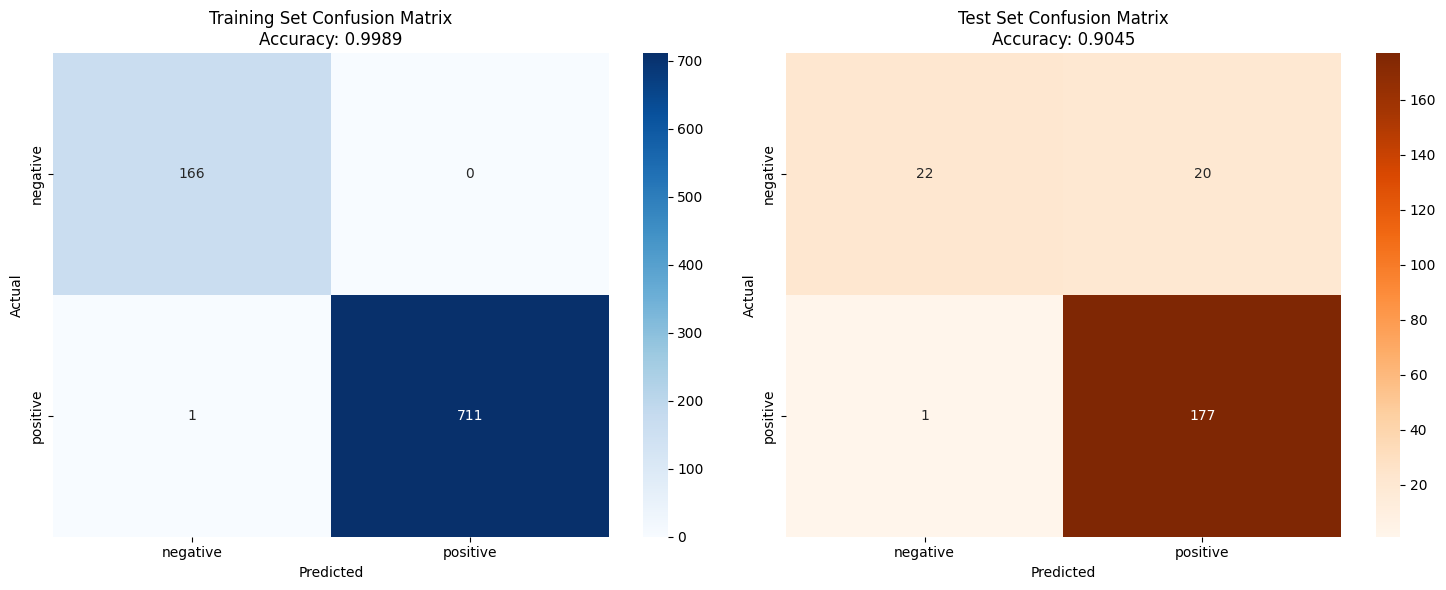


5️. TRAIN/TEST ACCURACY & LOSS VISUALIZATION...


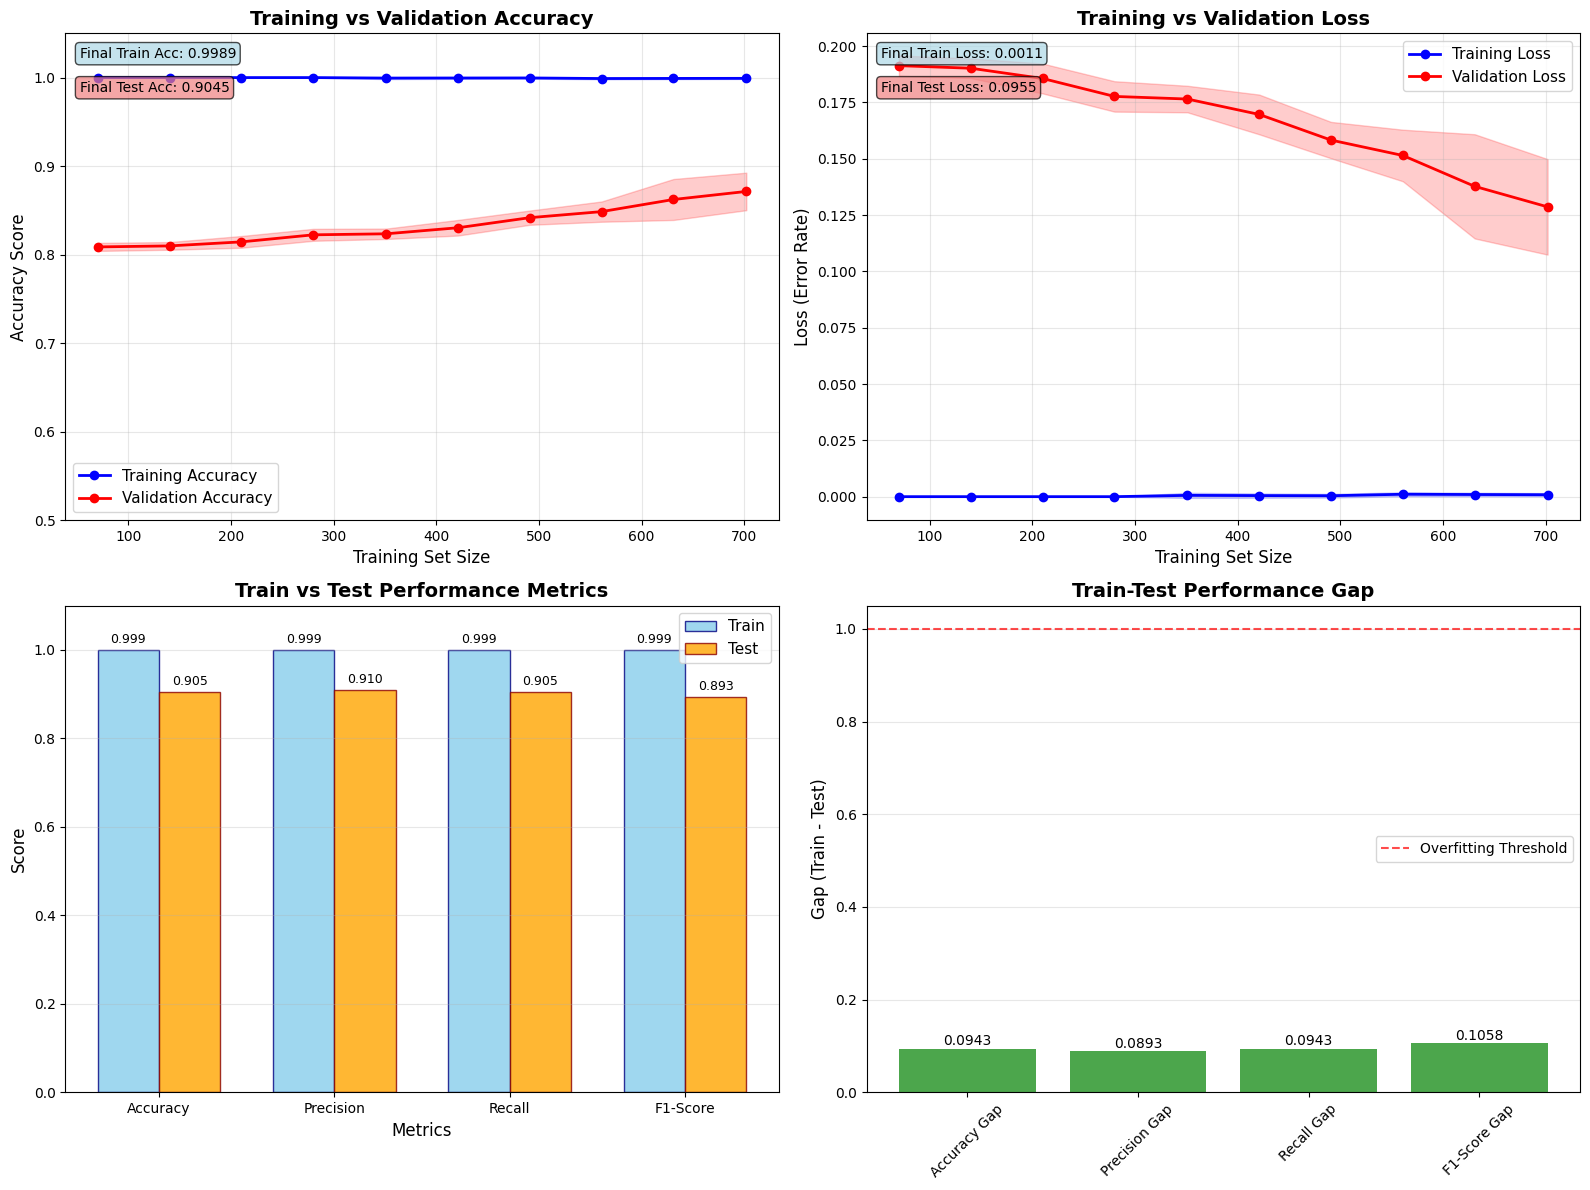

 Learning curves and performance visualization completed

6️. ERROR ANALYSIS...
 ERROR STATISTICS:
Total Test Samples: 220
Correctly Classified: 199 (90.45%)
Misclassified: 21 (9.55%)

 MISCLASSIFIED EXAMPLES (First 5):
--------------------------------------------------------------------------------

Error 1:
  Text: meski jauh selalu beli hp sini...
  Actual: negative
  Predicted: positive

Error 2:
  Text: mau beli hp dgm jamin kwalitas pernah ewa sini...
  Actual: negative
  Predicted: positive

Error 3:
  Text: tempat jual hp sepeda listrik aksesoris lengkap harga saing kota semua kru nya ramah undianya...
  Actual: negative
  Predicted: positive

Error 4:
  Text: layan cepat mbulet tanya via telpon layan baik masalah harga ragu sini murah...
  Actual: negative
  Predicted: positive

Error 5:
  Text: layan ramah enggak pelit info stock cepat tangap...
  Actual: negative
  Predicted: positive

 FINAL EVALUATION SUMMARY
 DATASET STATISTICS:
   Training Samples: 878
   Test Samples: 2

In [ ]:
# ===================================================================
# COMPREHENSIVE MODEL EVALUATION (MODIFIED)
# ===================================================================

print("\n" + "="*60)
print(" COMPREHENSIVE MODEL EVALUATION")
print("="*60)

# Import additional libraries for evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ===================================================================
# 1. PREPARE EVALUATION DATA
# ===================================================================
print("\n1. PREPARING EVALUATION DATA...")

# Transform data dengan TF-IDF
X_train_tfidf = tfidf_loaded.transform(X_train)
X_test_tfidf = tfidf_loaded.transform(X_test)

# Make predictions
y_train_pred = svm_model_loaded.predict(X_train_tfidf)
y_test_pred = svm_model_loaded.predict(X_test_tfidf)

print(f" Training set: {len(X_train)} samples")
print(f" Test set: {len(X_test)} samples")
print(f" Predictions generated for evaluation")

# ===================================================================
# 2. BASIC METRICS CALCULATION
# ===================================================================
print("\n2️. CALCULATING BASIC METRICS...")

# Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Precision, Recall, F1-Score (weighted average for multiclass)
train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)

train_recall = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)

train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

print(" BASIC METRICS SUMMARY:")
print("="*50)
print(f"{'Metric':<15} {'Train':<12} {'Test':<12} {'Difference':<12}")
print("-"*50)
print(f"{'Accuracy':<15} {train_accuracy:<12.4f} {test_accuracy:<12.4f} {abs(train_accuracy-test_accuracy):<12.4f}")
print(f"{'Precision':<15} {train_precision:<12.4f} {test_precision:<12.4f} {abs(train_precision-test_precision):<12.4f}")
print(f"{'Recall':<15} {train_recall:<12.4f} {test_recall:<12.4f} {abs(train_recall-test_recall):<12.4f}")
print(f"{'F1-Score':<15} {train_f1:<12.4f} {test_f1:<12.4f} {abs(train_f1-test_f1):<12.4f}")

# Check for overfitting
overfitting_threshold = 0.1
is_overfitting = (train_accuracy - test_accuracy) > overfitting_threshold

print(f"\n OVERFITTING ANALYSIS:")
print(f"   Train-Test Accuracy Gap: {train_accuracy - test_accuracy:.4f}")
if is_overfitting:
    print(f"WARNING: Possible overfitting detected!")
else:
    print(f"    Model appears to generalize well")

# ===================================================================
# 3. DETAILED CLASSIFICATION REPORT
# ===================================================================
print("\n3️. DETAILED CLASSIFICATION REPORT...")

print("\n TRAINING SET CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_train, y_train_pred, digits=4))

print("\n TEST SET CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_test, y_test_pred, digits=4))

# ===================================================================
# 4. CONFUSION MATRIX
# ===================================================================
print("\n4️. CONFUSION MATRIX ANALYSIS...")

# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Get unique labels
labels = svm_model_loaded.classes_

print(f"\n CONFUSION MATRIX - TRAINING SET:")
print("="*40)
print(f"Labels: {labels}")
print(cm_train)

print(f"\n CONFUSION MATRIX - TEST SET:")
print("="*40)
print(f"Labels: {labels}")
print(cm_test)

# Visualize confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels, ax=ax1)
ax1.set_title(f'Training Set Confusion Matrix\nAccuracy: {train_accuracy:.4f}')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Test confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=labels, yticklabels=labels, ax=ax2)
ax2.set_title(f'Test Set Confusion Matrix\nAccuracy: {test_accuracy:.4f}')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ===================================================================
# 5. TRAIN/TEST ACCURACY & LOSS VISUALIZATION
# ===================================================================
print("\n5️. TRAIN/TEST ACCURACY & LOSS VISUALIZATION...")

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    svm_model_loaded, X_train_tfidf, y_train, 
    cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy',
    random_state=42
)

# Calculate mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Calculate "loss" as (1 - accuracy)
train_loss_mean = 1 - train_scores_mean
train_loss_std = train_scores_std
val_loss_mean = 1 - val_scores_mean
val_loss_std = val_scores_std

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Train vs Test Accuracy
ax1.plot(train_sizes, train_scores_mean, 'o-', color='blue', linewidth=2, 
         markersize=6, label='Training Accuracy')
ax1.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')

ax1.plot(train_sizes, val_scores_mean, 'o-', color='red', linewidth=2, 
         markersize=6, label='Validation Accuracy')
ax1.fill_between(train_sizes, val_scores_mean - val_scores_std, 
                 val_scores_mean + val_scores_std, alpha=0.2, color='red')

ax1.set_xlabel('Training Set Size', fontsize=12)
ax1.set_ylabel('Accuracy Score', fontsize=12)
ax1.set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.5, 1.05)

# Add final accuracy values as text
ax1.text(0.02, 0.95, f'Final Train Acc: {train_accuracy:.4f}', 
         transform=ax1.transAxes, fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
ax1.text(0.02, 0.88, f'Final Test Acc: {test_accuracy:.4f}', 
         transform=ax1.transAxes, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))

# 2. Train vs Test Loss (Error Rate)
ax2.plot(train_sizes, train_loss_mean, 'o-', color='blue', linewidth=2, 
         markersize=6, label='Training Loss')
ax2.fill_between(train_sizes, train_loss_mean - train_loss_std, 
                 train_loss_mean + train_loss_std, alpha=0.2, color='blue')

ax2.plot(train_sizes, val_loss_mean, 'o-', color='red', linewidth=2, 
         markersize=6, label='Validation Loss')
ax2.fill_between(train_sizes, val_loss_mean - val_loss_std, 
                 val_loss_mean + val_loss_std, alpha=0.2, color='red')

ax2.set_xlabel('Training Set Size', fontsize=12)
ax2.set_ylabel('Loss (Error Rate)', fontsize=12)
ax2.set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Add final loss values as text
final_train_loss = 1 - train_accuracy
final_test_loss = 1 - test_accuracy
ax2.text(0.02, 0.95, f'Final Train Loss: {final_train_loss:.4f}', 
         transform=ax2.transAxes, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
ax2.text(0.02, 0.88, f'Final Test Loss: {final_test_loss:.4f}', 
         transform=ax2.transAxes, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))

# 3. Metrics Comparison Bar Chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_values = [train_accuracy, train_precision, train_recall, train_f1]
test_values = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax3.bar(x - width/2, train_values, width, label='Train', 
                color='skyblue', alpha=0.8, edgecolor='navy')
bars2 = ax3.bar(x + width/2, test_values, width, label='Test', 
                color='orange', alpha=0.8, edgecolor='darkred')

ax3.set_xlabel('Metrics', fontsize=12)
ax3.set_ylabel('Score', fontsize=12)
ax3.set_title('Train vs Test Performance Metrics', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics)
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim(0, 1.1)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)
             
for bar in bars2:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 4. Accuracy Gap Analysis
gap_data = {
    'Accuracy Gap': abs(train_accuracy - test_accuracy),
    'Precision Gap': abs(train_precision - test_precision),
    'Recall Gap': abs(train_recall - test_recall),
    'F1-Score Gap': abs(train_f1 - test_f1)
}

gap_names = list(gap_data.keys())
gap_values = list(gap_data.values())

colors = ['red' if gap > 1 else 'green' for gap in gap_values]
bars = ax4.bar(gap_names, gap_values, color=colors, alpha=0.7)

ax4.set_ylabel('Gap (Train - Test)', fontsize=12)
ax4.set_title('Train-Test Performance Gap', fontsize=14, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, gap_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{value:.4f}', ha='center', va='bottom', fontsize=10)

# Add threshold line
ax4.axhline(y=1, color='red', linestyle='--', alpha=0.7, 
            label='Overfitting Threshold')
ax4.legend(fontsize=10)

plt.tight_layout()
plt.show()

print(f" Learning curves and performance visualization completed")

# ===================================================================
# 6. ERROR ANALYSIS
# ===================================================================
print("\n6️. ERROR ANALYSIS...")

# Find misclassified samples
test_errors = y_test != y_test_pred
error_indices = np.where(test_errors)[0]

print(f" ERROR STATISTICS:")
print(f"Total Test Samples: {len(y_test)}")
print(f"Correctly Classified: {len(y_test) - len(error_indices)} ({(1-len(error_indices)/len(y_test))*100:.2f}%)")
print(f"Misclassified: {len(error_indices)} ({(len(error_indices)/len(y_test))*100:.2f}%)")

# Show some misclassified examples
if len(error_indices) > 0:
    print(f"\n MISCLASSIFIED EXAMPLES (First 5):")
    print("-"*80)
    
    X_test_list = X_test if isinstance(X_test, list) else X_test.tolist()
    y_test_list = y_test if isinstance(y_test, list) else y_test.tolist()
    
    for i, error_idx in enumerate(error_indices[:5]):
        print(f"\nError {i+1}:")
        print(f"  Text: {X_test_list[error_idx][:100]}...")
        print(f"  Actual: {y_test_list[error_idx]}")
        print(f"  Predicted: {y_test_pred[error_idx]}")

# ===================================================================
# 7. FINAL EVALUATION SUMMARY
# ===================================================================
print("\n" + "="*80)
print(" FINAL EVALUATION SUMMARY")
print("="*80)

print(f" DATASET STATISTICS:")
print(f"   Training Samples: {len(X_train)}")
print(f"   Test Samples: {len(X_test)}")
print(f"   Features: {X_train_tfidf.shape[1]} (TF-IDF)")
print(f"   Classes: {len(labels)} {list(labels)}")

print(f"\n PERFORMANCE METRICS:")
print(f"   Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"   Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Test Precision: {test_precision:.4f}")
print(f"   Test Recall: {test_recall:.4f}")
print(f"   Test F1-Score: {test_f1:.4f}")

print(f"\n MODEL ANALYSIS:")
print(f"   Overfitting: {'Yes' if is_overfitting else 'No'} (gap: {train_accuracy-test_accuracy:.4f})")
print(f"   Training Loss: {1-train_accuracy:.4f}")
print(f"   Test Loss: {1-test_accuracy:.4f}")
print(f"   Misclassification Rate: {len(error_indices)/len(y_test)*100:.2f}%")

print(f"\n MODEL EVALUATION COMPLETED!")
print("="*80)

# Pembuatan Kamus

In [ ]:
# 1. Setup Folder
folder_name = "kamus"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# ==========================================
# A. KAMUS INTERNAL (Kekuatan & Kelemahan Toko)
# ==========================================
internal_keywords = [
    # --- 1. Produk & Spesifikasi ---
    "produk", "barang", "unit", "item", "stok", "ketersediaan",
    "hp", "handphone", "telepon pintar", "gawai", "tablet",
    "android", "samsung", "oppo", "vivo", "xiaomi", "realme", "infinix", "iphone",
    "kondisi", "fisik", "mulus", "segel",
    "ori", "original", "asli", "palsu", "tiruan", "replika",
    "garansi", "resmi", "distributor", "imei", "blokir",
    "spek", "ram", "memori", "internal",
    "layar", "lcd", "layar sentuh", "speaker", "suara",
    "kelengkapan", "lengkap",
    
    # --- 2. Aksesoris ---
    "aksesoris", "pengisi daya", "charger", "kabel", "data", "kepala", "adaptor",
    "pelindung layar", "anti gores", "headphone", "headset",
    "pelindung", "casing", "kaca",
    "pengisi daya portabel", "kartu memori", "kartu sim",
    
    # --- 3. Pelayanan & SDM ---
    "pelayanan", "layanan", "servis", "jasa",
    "karyawan", "pegawai", "staf", "admin", "penjual", "pemasaran", "promotor",
    "mbak", "mas", "kakak", "bapak", "ibu", "pemilik", "bos",
    "sikap", "perilaku", "ramah", "sopan", "baik", "sabar", "senyum",
    "jutek", "judes", "galak", "sinis", "cuek", "acuh", "sombong", "kasar",
    "tanggapan", "balas", "pesan",
    "penjelasan", "info", "informasi", "edukasi",
    "cepat", "kilat", "gesit", "cekatan", "sigap",
    "lambat", "lama", "lelet", "menunggu", "nunggu", "antri",
    
    # --- 4. Harga & Transaksi ---
    "harga", "biaya", "tarif", "daftar harga",
    "murah", "terjangkau", "miring", "ekonomis", "mahal", "kemahalan",
    "bayar", "pembayaran", "transaksi", "beli", "belanja", "jual", "tukar tambah",
    "tunai", "debit", "kredit", "cicilan", "angsuran",
    "transfer", "pindai",
    "promo", "diskon", "potongan", "uang kembali", "bonus", "gratis", "hadiah",
    "nota", "kuitansi", "tagihan", "struk", "kembalian", "uang",
    
    # --- 5. Fasilitas & Lokasi ---
    "tempat", "lokasi", "toko", "konter", "gerai", "cabang",
    "ruang", "tunggu", "kursi", "sofa", "meja", "etalase",
    "pendingin ruangan", "ac", "dingin", "sejuk", "panas", "gerah", "pengap",
    "bersih", "rapi", "wangi", "harum", "kotor", "bau", "berantakan", "kumuh",
    "luas", "lega", "sempit", "sesak", "padat",
    "nyaman", "betah", "bising", "berisik", "tenang",
    "parkir", "parkiran", "motor", "mobil", "aman", "teduh",
    "toilet", "wc", "kamar mandi", "mushola", "internet", "antrian", 
]

# ==========================================
# B. KAMUS EKSTERNAL (Peluang & Ancaman)
# ==========================================
# Mencakup: Kompetitor, Tren, Ekonomi, Lingkungan
# (Hanya Bahasa Indonesia)
external_keywords = [
    # --- 1. Kompetitor & Pasar ---
    "kompetitor", "pesaing", "saingan", "lawan",
    "toko sebelah", "konter sebelah", "tempat lain", "toko lain",
    "harga pasar", "pasaran", "banding", "perbandingan",
    "pusat hp", "pusat elektronik", "mall", "toko sebelah",
    
    # --- 2. Platform Online (E-Commerce) ---
    "daring", "online", "toko online", "pasar online",
    "shopee", "tokopedia", "bukalapak", "lazada", "blibli",
    "tiktok", "keranjang kuning", "siaran langsung",
    "instagram", "facebook", "media sosial",
    "situs", "laman", "google", "peta", "ulasan",
    
    # --- 3. Pengiriman & Logistik (Pihak Ketiga) ---
    "pengiriman", "antar", "kurir", "ekspedisi", "paket",
    "jne", "jnt", "sicepat", "anteraja", "gosend", "grab", "gojek", "maxim",
    "ongkos kirim", "biaya antar", "bayar ditempat",
    "lama sampai", "rusak dijalan", "hilang", "salah alamat",
    
    # --- 4. Momen & Musim ---
    "lebaran", "idul fitri", "puasa", "ramadhan",
    "natal", "tahun baru", "imlek", "libur", "liburan", "cuti",
    "tanggal merah", "akhir pekan", "minggu", "malam minggu",
    "gajian", "awal bulan", "akhir bulan", "tanggal tua", "tanggal muda",
    "tunjangan hari raya", "thr", "bonus tahunan", "hari belanja nasional",
    
    # --- 5. Ekonomi & Lingkungan Makro ---
    "macet", "jalan", "akses", "rute", "banjir", "hujan", "cuaca",
    "pandemi", "wabah", "pembatasan",
    "langka", "susah dicari", "terbatas",
    
    # --- 6. Tren Teknologi ---
    "viral", "tren", "populer", "terkenal",
    "terbaru", "rilis", "peluncuran", "keluaran baru", "model baru",
    "sinyal", "jaringan", "penyedia layanan", "kartu perdana",
    "pembaruan", "peningkatan", "sistem operasi", "versi",
    "fitur", "canggih", 
]

# ==========================================
# C. Fungsi Penyimpanan
# ==========================================
def save_lexicon_extended(filename, keywords_list):
    file_path = os.path.join(folder_name, filename)
    # Ubah ke huruf kecil, hapus duplikat, dan urutkan abjad
    unique_words = sorted(list(set([k.lower() for k in keywords_list])))
    
    try:
        with open(file_path, 'w', encoding='utf-8') as f:
            for word in unique_words:
                f.write(word + '\n')
        print(f" Berhasil menyimpan: {file_path}")
        print(f"   Jumlah kata kunci: {len(unique_words)}")
    except Exception as e:
        print(f"Gagal menyimpan {filename}: {e}")

# ==========================================
# D. Eksekusi
# ==========================================
print("--- Memulai Pembuatan Kamus Lengkap (Bahasa Indonesia) ---")
save_lexicon_extended("kamus_internal.txt", internal_keywords)
save_lexicon_extended("kamus_eksternal.txt", external_keywords)

--- Memulai Pembuatan Kamus Lengkap (Bahasa Indonesia) ---
 Berhasil menyimpan: kamus\kamus_internal.txt
   Jumlah kata kunci: 199
 Berhasil menyimpan: kamus\kamus_eksternal.txt
   Jumlah kata kunci: 110


## Membuat File untuk Analisis SWOT

In [ ]:
# ==========================================
# 1. Konfigurasi Folder & File
# ==========================================
# PERUBAHAN: Menggunakan file hasil prediksi SVM
input_csv = 'swot_dataset_svm_final_validator.csv'       
output_folder = 'analisis_swot_validator'          
output_filename = 'analisis_swot_final_validator.xlsx' # Nama file output dibedakan agar tidak tertukar

# Buat folder output jika belum ada
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Folder '{output_folder}' siap digunakan.")

# Path lengkap untuk menyimpan file
output_path = os.path.join(output_folder, output_filename)

# ==========================================
# 2. Load Data & Kamus
# ==========================================
# Load Dataset
if os.path.exists(input_csv):
    df = pd.read_csv(input_csv)
    # Hapus data kosong jika ada
    df = df.dropna(subset=['text', 'sentiment'])
    print(f" Dataset SVM dimuat: {len(df)} ulasan.")
    
    # Cek sekilas apakah labelnya benar
    print("   Contoh sebaran label:", df['sentiment'].unique())
else:
    print(f"Error: File '{input_csv}' tidak ditemukan.")
    print("   Pastikan Anda sudah menjalankan 'Langkah 1' untuk generate file ini.")
    exit()

# Fungsi Load Kamus
def load_keywords(filepath):
    if os.path.exists(filepath):
        with open(filepath, 'r', encoding='utf-8') as f:
            return [line.strip().lower() for line in f.readlines() if line.strip()]
    return []

# Load dari folder 'kamus'
internal_keywords = load_keywords('kamus/kamus_internal.txt')
external_keywords = load_keywords('kamus/kamus_eksternal.txt')

# Cek ketersediaan kamus
if not internal_keywords or not external_keywords:
    print("Peringatan: Kamus kosong atau tidak ditemukan. Pastikan folder 'kamus' ada.")

# ==========================================
# 3. Logika Pemetaan SWOT
# ==========================================
def categorize_swot(row):
    text = str(row['text']).lower()
    sentiment = row['sentiment'] # Ini sekarang menggunakan hasil SVM
    
    # Cari kata kunci (regex boundary \b agar akurat, misal: 'as' tidak match 'panas')
    found_internal = [k for k in internal_keywords if re.search(r'\b' + re.escape(k) + r'\b', text)]
    found_external = [k for k in external_keywords if re.search(r'\b' + re.escape(k) + r'\b', text)]
    
    categories = []
    
    # --- LOGIKA SWOT BERDASARKAN SENTIMEN SVM ---
    # SVM Positive + Internal Keyword = STRENGTH
    if sentiment == 'positive' and found_internal:
        categories.append('STRENGTH')
        
    # SVM Negative + Internal Keyword = WEAKNESS
    if sentiment == 'negative' and found_internal:
        categories.append('WEAKNESS')
        
    # SVM Positive + External Keyword = OPPORTUNITY
    if sentiment == 'positive' and found_external:
        categories.append('OPPORTUNITY')
        
    # SVM Negative + External Keyword = THREAT
    if sentiment == 'negative' and found_external:
        categories.append('THREAT')
    
    # Gabungkan semua kata kunci yang ditemukan untuk referensi
    all_keywords = list(set(found_internal + found_external))
    
    return categories, all_keywords

# ==========================================
# 4. Eksekusi & Formatting
# ==========================================
swot_data = {
    'STRENGTH': [],
    'WEAKNESS': [],
    'OPPORTUNITY': [],
    'THREAT': []
}

print("Sedang melakukan pemetaan SWOT menggunakan label SVM...")

count_mapped = 0
for index, row in df.iterrows():
    cats, keywords = categorize_swot(row)
    
    if cats:
        count_mapped += 1
        
    for cat in cats:
        swot_data[cat].append({
            'Ulasan': row['text'],
        })

print(f"   Berhasil memetakan {count_mapped} dari {len(df)} ulasan ke dalam kategori SWOT.")

# Buat DataFrame terpisah untuk setiap kategori agar rapi di Excel
dfs = []
stats = {}

for category in ['STRENGTH', 'WEAKNESS', 'OPPORTUNITY', 'THREAT']:
    temp_df = pd.DataFrame(swot_data[category])
    stats[category] = len(temp_df)
    
    # Rename kolom dengan prefix kategori
    if not temp_df.empty:
        temp_df.columns = [f"{category}_{col}" for col in temp_df.columns]
    
    dfs.append(temp_df)

# Gabungkan secara horizontal (concat)
final_df = pd.concat(dfs, axis=1)

# ==========================================
# 5. Simpan ke Folder
# ==========================================
try:
    final_df.to_excel(output_path, index=False)
    print(f"\n SUKSES! Analisis SWOT (basis SVM) tersimpan.")
    print(f"   Lokasi : {output_path}")
    print("\nStatistik Temuan:")
    for cat, count in stats.items():
        print(f"   - {cat}: {count} butir")
        
except Exception as e:
    print(f"\nGagal menyimpan file: {e}")

 Dataset SVM dimuat: 1656 ulasan.
   Contoh sebaran label: ['positive' 'negative']
Sedang melakukan pemetaan SWOT menggunakan label SVM...
   Berhasil memetakan 1344 dari 1656 ulasan ke dalam kategori SWOT.

 SUKSES! Analisis SWOT (basis SVM) tersimpan.
   Lokasi : analisis_swot\analisis_swot_final.xlsx

Statistik Temuan:
   - STRENGTH: 1133 butir
   - WEAKNESS: 206 butir
   - OPPORTUNITY: 53 butir
   - THREAT: 22 butir


# Testing

In [ ]:
print("LOADING MODEL & KAMUS...")
model = joblib.load(r'D:\Kuliah\Skripsi\Scraping\model_hasil\svm_sentiment_model.pkl')
vectorizer = joblib.load(r'D:\Kuliah\Skripsi\Scraping\model_hasil\tfidf_vectorizer.pkl')

with open('kamus/kamus_internal.txt', 'r') as f:
    kamus_internal = [line.strip().lower() for line in f if line.strip()]

with open('kamus/kamus_eksternal.txt', 'r') as f:
    kamus_eksternal = [line.strip().lower() for line in f if line.strip()]

LOADING MODEL & KAMUS...


In [ ]:
daftar_review = [
    "pelayanannya ramah dan cepat",
    "Punya pengalaman beli iPhone yang cukup mengecewakan di ‘toko sebelah’ area suhat yang lebih besar dan punya nama. Syukurlah disini baik banget mbak yang bantu ngecek, informatif, dan tanggap. Thankyou mbak Via. Ga sempet moto mbaknya. Tapi aku pelanggan yg akan loyal kalau pelayanan baik. Pastinya akan memilih beli disini kalau cari iPhone lagi.",
    "sangat mengecewakan, lama sekali",
    "gercep, pelayanannya cepat dan ramah",
    "sangat lama untuk pelayanannya",
    "saya kecewa karena menunggu lama"
]

hasil_batch = []
for i, rev in enumerate(daftar_review, 1):
    # Preprocessing
    text = rev.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = [slang_dict.get(t, t) for t in text.split()]
    text = stopword_remover.remove(' '.join(tokens))
    text = ' '.join([stemmer.stem(t) for t in text.split() if len(t) >= 2])
    
    # Prediksi
    sentiment = model.predict(vectorizer.transform([text]))[0]
    
    # SWOT
    kata_int = [k for k in kamus_internal if k in rev.lower()]
    kata_ext = [k for k in kamus_eksternal if k in rev.lower()]
    
    swot = []
    if sentiment == 'positive' and kata_int:
        swot.append('STRENGTH')
    if sentiment == 'negative' and kata_int:
        swot.append('WEAKNESS')
    if sentiment == 'positive' and kata_ext:
        swot.append('OPPORTUNITY')
    if sentiment == 'negative' and kata_ext:
        swot.append('THREAT')
    
    swot_str = ', '.join(swot) if swot else '-'
    
    print(f"\n{i}. {rev}")
    print(f"   Sentimen: {sentiment.upper()} | SWOT: {swot_str}")
    
    hasil_batch.append({
        'Review': rev,
        'Sentimen': sentiment,
        'SWOT': swot_str
    })
    


1. pelayanannya ramah dan cepat
   Sentimen: POSITIVE | SWOT: STRENGTH

2. Punya pengalaman beli iPhone yang cukup mengecewakan di ‘toko sebelah’ area suhat yang lebih besar dan punya nama. Syukurlah disini baik banget mbak yang bantu ngecek, informatif, dan tanggap. Thankyou mbak Via. Ga sempet moto mbaknya. Tapi aku pelanggan yg akan loyal kalau pelayanan baik. Pastinya akan memilih beli disini kalau cari iPhone lagi.
   Sentimen: POSITIVE | SWOT: STRENGTH, OPPORTUNITY

3. sangat mengecewakan, lama sekali
   Sentimen: NEGATIVE | SWOT: WEAKNESS

4. gercep, pelayanannya cepat dan ramah
   Sentimen: POSITIVE | SWOT: STRENGTH

5. sangat lama untuk pelayanannya
   Sentimen: NEGATIVE | SWOT: WEAKNESS

6. saya kecewa karena menunggu lama
   Sentimen: NEGATIVE | SWOT: WEAKNESS
